In [1]:
import google.cloud.bigquery as bq
import google.cloud.bigquery.dbapi as bqapi
import pandas as pd
import tqdm


tqdm.tqdm.pandas()

In [2]:
from contextlib import closing

bq_client = bq.Client()
query = "SELECT published, body FROM Articles.CleanedArticles"
results = []

with closing(bqapi.Connection(client=bq_client)) as conn:
    with closing(conn.cursor()) as cursor:
        cursor.execute(query)
        for r in cursor.fetchall():
            results.append(list(r))

result_df = pd.DataFrame(results, columns=["published", "body"])
result_df.head()

,published,body
0,2023-10-23 21:53:05+00:00,Oct 23 - The West Antarctic Ice Sheet will con...
1,2023-10-23 12:32:25+00:00,"LONDON, Oct 23 (Reuters) - Companies including..."
2,2023-10-26 01:32:04+00:00,October 26 - Top-seeded Russian Daniil Medvede...
3,2023-10-18 15:24:00.111000+00:00,"October 18 - In 2014, The Guardian published a..."
4,2023-10-18 22:22:58+00:00,Oct 18 (Reuters) - A U.S. appeals court upheld...


In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(result_df.body)
words_count = []
for d in tqdm.tqdm(docs, total=result_df.shape[0]):
    words_count.append(len([token for token in d]))
    
result_df["words_count"] = words_count

100%|██████████| 41095/41095 [19:22<00:00, 35.34it/s]


In [4]:
result_df.head()

,published,body,words_count
0,2023-10-23 21:53:05+00:00,Oct 23 - The West Antarctic Ice Sheet will con...,482
1,2023-10-23 12:32:25+00:00,"LONDON, Oct 23 (Reuters) - Companies including...",404
2,2023-10-26 01:32:04+00:00,October 26 - Top-seeded Russian Daniil Medvede...,368
3,2023-10-18 15:24:00.111000+00:00,"October 18 - In 2014, The Guardian published a...",1648
4,2023-10-18 22:22:58+00:00,Oct 18 (Reuters) - A U.S. appeals court upheld...,620


In [7]:
result_df["date"] = result_df.published.apply(lambda x: x.date())
result_df.head()

,published,body,words_count,date
0,2023-10-23 21:53:05+00:00,Oct 23 - The West Antarctic Ice Sheet will con...,482,2023-10-23
1,2023-10-23 12:32:25+00:00,"LONDON, Oct 23 (Reuters) - Companies including...",404,2023-10-23
2,2023-10-26 01:32:04+00:00,October 26 - Top-seeded Russian Daniil Medvede...,368,2023-10-26
3,2023-10-18 15:24:00.111000+00:00,"October 18 - In 2014, The Guardian published a...",1648,2023-10-18
4,2023-10-18 22:22:58+00:00,Oct 18 (Reuters) - A U.S. appeals court upheld...,620,2023-10-18


In [8]:
date_df = result_df.groupby("date").agg({"words_count": "sum"})
date_df.head()

,words_count
date,
2023-04-06,139959
2023-04-07,62566
2023-04-08,22754
2023-04-09,18197
2023-04-10,91520


<Axes: xlabel='date'>

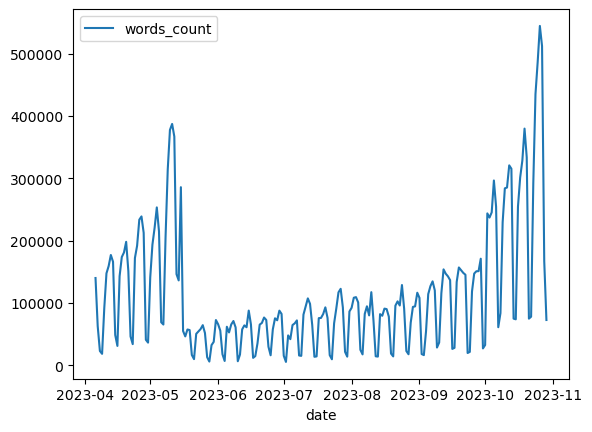

In [9]:
date_df.plot()